# Introduction

This notebook presents a method to train embedding layer using __Word2Vec Skip-Gram__ method on __Wikipedia text8__ dataset.

We are going to work with [text8](http://mattmahoney.net/dc/textdata) dataset. It is 100MB of cleaned English Wikipedia text. $\text{10MB} = 10^8$ hence text8

__Dataset:__
* [Large Text Compression Benchmark - About the test data](http://mattmahoney.net/dc/textdata) - download file named [text8.zip](http://mattmahoney.net/dc/text8.zip) and unzip it.

__References:__
* [Word2Vec Tutorial - The Skip-Gram Model](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) - plain English tutorial on Skip-Grams
* [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/abs/1301.3781) - first skip-gram paper
* [Distributed Representations of Words and Phrases and their Compositionality](https://arxiv.org/abs/1310.4546) - follow up paper with improvements

# Imports

In [1]:
import time
import math
import collections
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Read Data

Dataset location

In [4]:
dataset_location = '/home/marcin/Datasets/wiki-text8/text8'

In [5]:
with open(dataset_location, 'r') as f:
    text = f.read()
print(text[:500])

 anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philoso


Dataset is cleaned, it contains only lowercase letters and spaces

In [6]:
print(sorted(set(text)))

[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [7]:
words_raw = text.split()
print(words_raw[:20])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english']


In [8]:
print('Total words:', len(words_raw))
print('Unique words:', len(set(words_raw)))

Total words: 17005207
Unique words: 253854


# Preprocess the Data

First we will look at word-count distribution

In [9]:
words_counter = collections.Counter(words_raw)
print('WORD : COUNT')
for w in list(words_counter)[:10]:
    print(w, ':', words_counter[w])

WORD : COUNT
anarchism : 303
originated : 572
as : 131815
a : 325873
term : 7219
of : 593677
abuse : 563
first : 28810
used : 22737
against : 8432


Lets plot word-counts on linear and logarithmic scales

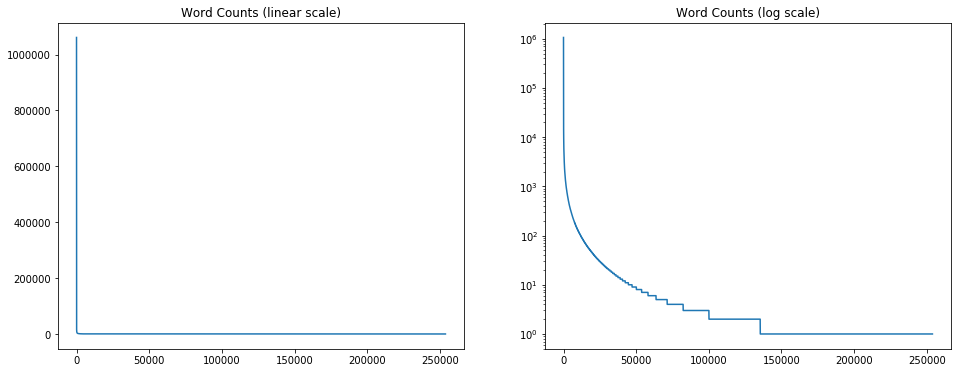

In [10]:
sorted_all = np.array(sorted(list(words_counter.values()), reverse=True))
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[16,6])
ax1.plot(sorted_all); ax1.set_title('Word Counts (linear scale)')
ax2.plot(sorted_all); ax2.set_title('Word Counts (log scale)')
ax2.set_yscale('log')

This is extremely sharp distribution. Some words appear over 1 million times, while over 100k words appear only once.

**Common Words**

Lets have a look at the most common words.

In [11]:
words_counter.most_common()[:10]

[('the', 1061396),
 ('of', 593677),
 ('and', 416629),
 ('one', 411764),
 ('in', 372201),
 ('a', 325873),
 ('to', 316376),
 ('zero', 264975),
 ('nine', 250430),
 ('two', 192644)]

We will deal with this later on using _subsampling_ as described by Mikolov.

**Rare Words**

Lets look at some of of the uncommon words

In [12]:
words_counter.most_common()[-10:]

[('kajn', 1),
 ('gorbacheva', 1),
 ('mikhailgorbachev', 1),
 ('englander', 1),
 ('workmans', 1),
 ('erniest', 1),
 ('metzada', 1),
 ('metzuda', 1),
 ('fretensis', 1),
 ('exortation', 1)]

Words like 'metzanda' or 'metzunda' are so rare (first ever time I see these) we are not concerned about them when building our NLP system. We will subsequently drop all words that 5 or less times.

**Create dictionaries**

Tokenize words, but keep only ones that occur six or more times

In [15]:
i2w = {i : w for i, (w, c) in enumerate(words_counter.most_common()) if c > 5}
w2i = {w : i for i, w in i2w.items()}
print('Number of words after filter:', len(i2w))

Number of words after filter: 63641


Confirm both dictionaries check

In [16]:
for i in range(10):
    word = i2w[i]
    print(i, ':', word, ':', w2i[word])

0 : the : 0
1 : of : 1
2 : and : 2
3 : one : 3
4 : in : 4
5 : a : 5
6 : to : 6
7 : zero : 7
8 : nine : 8
9 : two : 9


**Tokenize**

In [17]:
words_tok = [w2i[w] for w in words_raw if w in w2i]
print('Number of words after removing uncommon:', len(words_tok))

Number of words after removing uncommon: 16680599


This is our text, with uncommon words removed and converted to tokens:

In [18]:
print(words_tok[:100])

[5233, 3080, 11, 5, 194, 1, 3133, 45, 58, 155, 127, 741, 476, 10571, 133, 0, 27349, 1, 0, 102, 854, 2, 0, 15067, 58112, 1, 0, 150, 854, 3580, 0, 194, 10, 190, 58, 4, 5, 10712, 214, 6, 1324, 104, 454, 19, 58, 2731, 362, 6, 3672, 0, 708, 1, 371, 26, 40, 36, 53, 539, 97, 11, 5, 1423, 2757, 18, 567, 686, 7088, 0, 247, 5233, 10, 1052, 27, 0, 320, 248, 44611, 2877, 792, 186, 5233, 11, 5, 200, 602, 10, 0, 1134, 19, 2621, 25, 8983, 2, 279, 31, 4147, 141, 59, 25, 6437]


**Subsampling**

Equation from the paper, where $P(w_i)$ is probability to _drop_ certain word, $f(w_i)$ is a frequency and $t$ is a parameter

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

Calculate probabilities

In [19]:
threshold = 1e-5

tokens_counter = collections.Counter(words_tok)    # token : num_occurances

prob_drop = {}
for tok, count in tokens_counter.items():
    word_freq = count / len(words_tok)
    prob_drop[tok] = 1 - math.sqrt(threshold / word_freq)

Print probabilities for some words, note that for frequent words like 'the' drop probability is quite high while for uncommon words it is actually negative (meaning don't ever drop)

In [20]:
print('word        occurances     p_drop')
for word in ['the', 'at', 'dog', 'cat', 'extravagant', 'sustaining']:
    token = w2i[word]
    print(f'{word:11}    '
          f'{tokens_counter[token]:7}     '
          f'{prob_drop[token]: .2f}')

word        occurances     p_drop
the            1061396      0.99
at               54576      0.94
dog                958      0.58
cat                692      0.51
extravagant         51     -0.81
sustaining          49     -0.85


Drop words according to probability (we could do this on per-batch basis)

In [21]:
words_fin = [tok for tok in words_tok if np.random.rand() > prob_drop[tok] ]

**Generate Training Dataset**

<img src="assets/skipgram_batches.png" />

For each word sample the surrounding _context_ of $R$ words on each side. To reflect the fact that more distant words are less relevant we pick $R$ as a random integer in range $[1:\text{max_window}]$ This could also be done on per-batch basis

In [22]:
max_window = 5

data_x, data_y = [], []

for i, tok in enumerate(words_fin):
    R = np.random.randint(1, max_window+1)
    start = max(i - R, 0)
    stop = i + R
    targets = words_fin[start:i] + words_fin[i+1:stop+1]
    
    data_x.extend([tok] * len(targets))
    data_y.extend(targets)    

Show sample data

In [23]:
print('Original:', words_fin[:10])
print('Inputs: ', data_x[:10])
print('Targets:', data_y[:10])

Original: [5233, 3080, 741, 10571, 133, 27349, 2, 15067, 58112, 854]
Inputs:  [5233, 5233, 5233, 5233, 3080, 3080, 3080, 741, 741, 10571]
Targets: [3080, 741, 10571, 133, 5233, 741, 10571, 3080, 10571, 5233]


Convert to tensors

In [24]:
train_x = torch.tensor(data_x).to(device)
train_y = torch.tensor(data_y).to(device)

# Skip-Gram Model

In [31]:
class SkipGram(nn.Module):
    def __init__(self, n_vocab, n_embed):
        super(SkipGram, self).__init__()
        self.embed = nn.Embedding(num_embeddings=n_vocab, embedding_dim=n_embed)
        self.fc = nn.Linear(n_embed, n_vocab)
        
    def forward(self, x):
        x = self.embed(x)
        return self.fc(x)

In [32]:
n_vocab = len(w2i)  # size of vocabulary
n_embed = 300       # size of embedding dimension

In [33]:
model = SkipGram(n_vocab, n_embed)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [34]:
def get_most_similar(model, test_words, topk):
    result = {}
    with torch.no_grad():
        for word in test_words:
            tok = w2i[word]
            x = torch.tensor([tok]).to(device)
            x_embed = model.embed(x)
            cos_sim = F.cosine_similarity(x_embed, model.embed.weight)
            _, indices = cos_sim.topk(topk+1)  # +1 because self is always most similar
            similar_words = [i2w[tok.item()] for tok in indices]
            result[word] = similar_words[1:]
        
    return result

In [35]:
n_batch = 3072
nb_epochs = 1

trace = {'loss': []}  # per iteration

iteration = 0
for epoch in range(1):

    time_start = time.time()

    #
    #   Train Model
    #
    model.train()
    for i in range(0, len(train_x), n_batch):

        # Pick mini-batch (over seqence dimension)
        inputs = train_x[i:i+n_batch]    # [n_batch]
        targets = train_y[i:i+n_batch]   # [n_batch]
        
        # Optimize
        optimizer.zero_grad()
        outputs = model(inputs)  # logits
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Record
        trace['loss'].append( loss.item() )
                
        if i % (100*n_batch) == 0:
            percent_complete = i * 100 / len(train_x)
            time_delta = time.time() - time_start
            print(f'Epoch: {epoch:3} ({percent_complete:.0f}%)     '
                f'Loss: {loss:.4f}     Time: {time_delta:.2f}s')
            
            test_words = ['king', 'rock', 'dog', 'jump', 'five', 'http']
            res_dict = get_most_similar(model, test_words, topk=5)
            for word, similar in res_dict.items():
                print(f'{word:<6}:', ' '.join(similar))
            print('----------')
            
            time_start = time.time()
            


Epoch:   0 (0%)     Loss: 11.2223     Time: 0.13s
king  : breakbeat devotions sv defends inserting
rock  : sociologist hypnotists fita contained octahedral
dog   : unclassified byng meridian midrashim laos
jump  : twice mickiewicz torturing intermarriage utmost
five  : stott bestiaries pirenne reinforcement iquique
http  : magnetospheric fluctuates mekhilta aggressors ductile
----------
Epoch:   0 (1%)     Loss: 10.9685     Time: 12.20s
king  : breakbeat devotions sv defends inserting
rock  : sociologist hypnotists fita contained octahedral
dog   : unclassified byng laos meridian dubnium
jump  : twice mickiewicz torturing utmost intermarriage
five  : stott bestiaries pirenne faction reinforcement
http  : fluctuates magnetospheric aggressors mekhilta ductile
----------
Epoch:   0 (2%)     Loss: 11.0106     Time: 12.13s
king  : breakbeat inserting sv defends crumpled
rock  : sociologist hypnotists contained fita octahedral
dog   : unclassified byng laos meridian dubnium
jump  : twice mic

Epoch:   0 (23%)     Loss: 10.3056     Time: 13.06s
king  : cushions breakbeat navarro defends devotions
rock  : octahedral fita sociologist hypnotists contained
dog   : byng unclassified meridian midrashim dubnium
jump  : twice utmost mickiewicz torturing intermarriage
five  : stott faction bestiaries hike affluent
http  : fluctuates magnetospheric ductile barbarossa slayton
----------
Epoch:   0 (24%)     Loss: 9.9083     Time: 13.04s
king  : cushions breakbeat navarro devotions obituary
rock  : octahedral fita sociologist hypnotists contained
dog   : byng unclassified meridian midrashim dubnium
jump  : twice utmost mickiewicz torturing intermarriage
five  : stott faction hike bestiaries affluent
http  : fluctuates magnetospheric ductile by barbarossa
----------
Epoch:   0 (25%)     Loss: 10.3970     Time: 13.00s
king  : cushions breakbeat navarro defends devotions
rock  : octahedral sociologist fita hypnotists contained
dog   : byng unclassified meridian midrashim dubnium
jump  : tw

Epoch:   0 (48%)     Loss: 10.7360     Time: 12.98s
king  : obituary cushions navarro breakbeat devotions
rock  : octahedral fita sociologist sam hypnotists
dog   : unclassified byng outraged cows yogi
jump  : twice utmost mickiewicz intermarriage torturing
five  : stott two gallen affluent chilean
http  : by fluctuates slayton uprooted magnetospheric
----------
Epoch:   0 (49%)     Loss: 10.6004     Time: 13.01s
king  : obituary ruler cushions breakbeat navarro
rock  : octahedral sociologist fita sam hypnotists
dog   : unclassified byng outraged cows yogi
jump  : twice utmost mickiewicz intermarriage torturing
five  : stott two gallen affluent hungarians
http  : html uprooted slayton by fluctuates
----------
Epoch:   0 (50%)     Loss: 11.1435     Time: 12.94s
king  : obituary cushions breakbeat ruler navarro
rock  : octahedral sociologist fita sam skeleton
dog   : unclassified byng outraged yogi cows
jump  : twice utmost mickiewicz intermarriage torturing
five  : stott two seven galle

Epoch:   0 (74%)     Loss: 10.5691     Time: 13.02s
king  : obituary maddox devotions heir ingenious
rock  : octahedral sociologist foxhound skeleton thyme
dog   : cows byng unclassified yogi padre
jump  : twice boasts utmost mickiewicz surfboard
five  : two zero seven three six
http  : html org medvedev google se
----------
Epoch:   0 (75%)     Loss: 9.7746     Time: 12.98s
king  : obituary maddox heir devotions tot
rock  : octahedral sociologist funk skeleton foxhound
dog   : cows byng unclassified yogi padre
jump  : twice boasts mickiewicz utmost surfboard
five  : two seven zero nine six
http  : html org medvedev google se
----------
Epoch:   0 (76%)     Loss: 10.3947     Time: 12.98s
king  : maddox obituary devotions heir tot
rock  : octahedral sociologist funk skeleton negev
dog   : unclassified cows byng yogi jehu
jump  : twice boasts utmost mickiewicz surfboard
five  : two zero seven six nine
http  : html org se medvedev google
----------
Epoch:   0 (77%)     Loss: 10.2181     T

After one epoch it picks up numbers and web domains. It needs couple more epochs at lest.